# Key Concepts in this Notebook
https://www.youtube.com/watch?v=TKjjlp5_r7o

https://www.youtube.com/watch?v=Qnk0vVpqoNY

Playlist:
https://www.youtube.com/watch?v=N0crN8YnF8Y&list=PL2VXyKi-KpYttggRATQVmgFcQst3z6OlX

# Importing the Required Libraries

In [1]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# import nltk
# nltk.download("stopwords")
import pandas as pd
import numpy as np
import json
import glob
import langdetect
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy
import spacy
from spacy.language import Language
from langdetect import detect

# vis
import pyLDAvis
import pyLDAvis.gensim_models

# ignoring deprecation warning
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Preparing the Data

Modelling

In [2]:
df = pd.read_csv('lemmatized_csv_with_lang.csv', sep=";", low_memory=False)

In [3]:
df.head(1)

,lemmatized_text,lang
0,swimming world ncaa current policy science eve...,en


In [4]:
stop_words = ["amp"] + [stopwords.words(language) for language in stopwords.fileids()]    

def gen_words(texts):
    final = []
    for text in texts:
        try:
            # deacc = True -> normalize text with accent mark
            new = gensim.utils.simple_preprocess(text, deacc = True)
            removed_stopwords = [item for item in new if item not in stop_words]
            final.append(removed_stopwords)
        except:
            continue
    return(final)

In [5]:
data_words = gen_words(df[df["lang"] == "en"]["lemmatized_text"])

In [6]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [7]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 6,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 30,
                                            alpha = "auto")

# Visualizing the Data

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds = "mmds", R = 10)
vis

/home/mariafshan/miniconda3/envs/lda/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/mariafshan/miniconda3/envs/lda/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/mariafshan/miniconda3/envs/lda/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/mariafshan/miniconda3/envs/lda/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.153614  0.392667       1        1  26.029032
1     -0.126858 -0.385885       2        1  22.560444
4     -0.394909 -0.072663       3        1  21.534554
5     -0.245889  0.296051       4        1  15.316034
2      0.260121 -0.282815       5        1   8.024895
0      0.353921  0.052645       6        1   6.535042, topic_info=         Term          Freq         Total Category  logprob  loglift
20      woman  19736.000000  19736.000000  Default  10.0000  10.0000
24      women  15321.000000  15321.000000  Default   9.0000   9.0000
40    swimmer  15427.000000  15427.000000  Default   8.0000   8.0000
77     record  14097.000000  14097.000000  Default   7.0000   7.0000
51      sport  12659.000000  12659.000000  Default   6.0000   6.0000
...       ...           ...           ...      ...      ...      ...
1648   online    628.726389    629.568051   Topic6  -4.0086   2.7267
210       boy    527.099791    527.930644   Topic6  -4.1849   2.7264
284      week    456.109975    456.939672   Topic6  -4.3296   2.7262
175   example    451.932634    452.762777   Topic6  -4.3388   2.7262
463       all    444.797440    445.629038   Topic6  -4.3547   2.7261

[70 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
41        1  0.999782    advantage
463       6  0.998588          all
59        3  0.999834      athlete
134       5  0.998951          big
42        1  0.999809   biological
210       6  0.998237          boy
754       4  0.999432   competitor
155       6  0.999091  controversy
175       6  0.998315      example
165       6  0.999030         fact
433       4  0.999623         fair
44        1  0.999960       female
494       5  0.998892        final
540       4  0.999507         free
157       5  0.999016       gender
109       2  0.999465         girl
177       3  0.999855         good
335       6  0.999487         here
317       5  0.999586        issue
16        2  0.999885         just
54        1  0.999904         male
55        3  0.999945          man
72        6  0.998694       medium
28        2  0.999751          men
348       3  0.999872         more
6         4  0.999857         ncaa
350       2  0.999592          new
337       1  0.999642          now
1648      6  0.999098       online
178       5  0.999511         only
576       5  0.999536       parent
2419      1  0.999707         penn
73        3  0.999753       people
74        6  0.998890        point
145       4  0.999649         pool
746       2  0.999318      protest
389       5  0.999223         real
374       3  0.999554       really
77        1  0.999936       record
371       4  0.999662        right
508       2  0.999655         rule
322       5  0.999740       school
204       3  0.999877       second
396       5  0.998693    situation
75        1  0.999887           so
51        2  0.999920        sport
361       3  0.999387         swim
40        1  0.999939      swimmer
11        4  0.999888     swimming
30        2  0.999889         team
1148      1  0.999845     teammate
148       3  0.999847         time
68        4  0.999949  transgender
160       4  0.999605         very
284       6  0.997944         week
1134      5  0.999378      weekend
20        3  0.999933        woman
24        2  0.999968        women
12        4  0.999322        world
87        2  0.999817         year, R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 6, 3, 1])

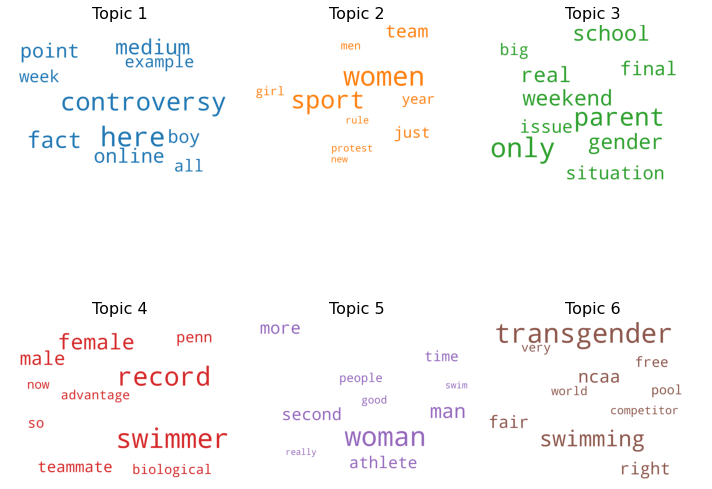

In [10]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  # stopwords=stop_words,
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()